<a href="https://colab.research.google.com/github/avishkar58/covid19_datasets/blob/master/Data_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# International Dataset Exploratory Analysis
This notebook provides some basic exploratory analysis of some of a selection of fields available the [DELVE Covid 19 international dataset](https://github.com/rs-delve/covid19_datasets) 

**WORK IN PROGRESS**

In [0]:
#@title Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import clear_output, display
import ipywidgets as widgets

path = 'https://raw.githubusercontent.com/rs-delve/covid19_datasets/master/dataset/combined_dataset_latest.csv'
df = pd.read_csv(path, parse_dates=['DATE'])

## New deaths per day in a selection of countries (log scale)
At a glance it looks like the daily new deaths in these countries is on the decline. \

The vertical lines in the plot are on Sundays. It seems that some countries tend to report fewer deaths on certain days of the week. For example, Germany and the UK both appear to have dips in new deaths on Mondays.

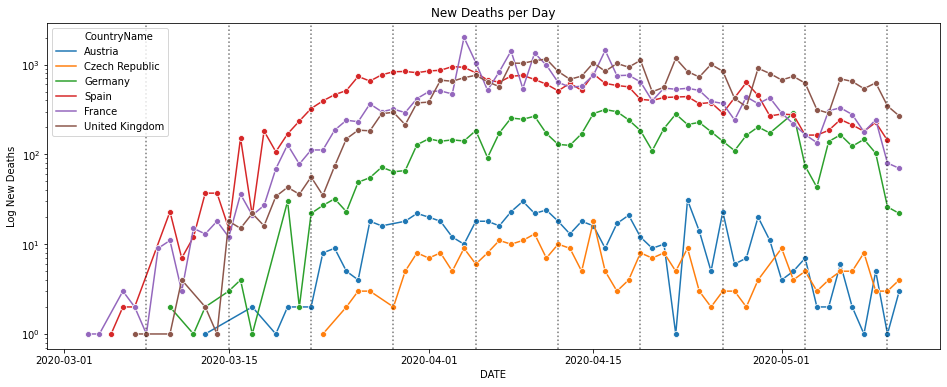

In [20]:
#@title New Deaths Per Day Plot
isos = ['AUT', 'CZE', 'DEU', 'ESP', 'FRA', 'GBR']
start_date = '2020-03-01'
plot_df = df[df.ISO.isin(isos)].query(f'DATE > "{start_date}"').replace(0, np.nan)

sundays = plot_df.DATE[plot_df.DATE.dt.dayofweek == 6]

fig, ax = plt.subplots(figsize=(16, 6))
sns.lineplot(data=plot_df, x='DATE', y='new_deaths', hue='CountryName', marker='o')
plt.yscale('log')
plt.title('New Deaths per Day')
plt.ylabel('Log New Deaths')

for sunday in sundays:
  plt.axvline(sunday, c='k', ls=':', alpha=0.1)

plt.show()



## Smoothed deaths with Stringency Index
**Select a country from the dropdown to re-generate the plot**

Since the number of new deaths depends partially on the day of the week, we take a rolling 7 day centered mean to smooth out this artifact.

The Oxford Government Response Tracker dataset provides a Stringency Index measure, which is a value between 0 and 1 that summarizes the level of active NPIs in a country.

Dropdown(description='Country:', index=150, options=(('Afghanistan', 'Afghanistan'), ('Albania', 'Albania'), (…

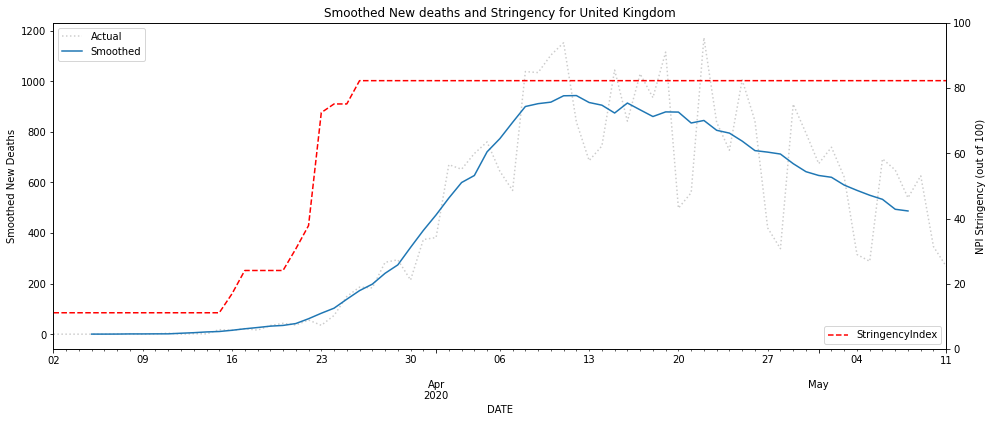

In [40]:
#@title Smoothed Deaths and Stringency plot

def add_widget(country):
  country_widget = widgets.Dropdown(
      options=sorted([(c, c) for c in df.CountryName.unique()]),
      value=country,
      description='Country:',
  )

  country_widget.observe(lambda d: plot_country(d['new']), 'value')
  display(country_widget)

def plot_country(country):
  clear_output()
  add_widget(country)
  fig, ax = plt.subplots(figsize=(16, 6))
  ax2 = ax.twinx()
  ax2.set_ylim(0, 100)
  plot_df = df.query(f'CountryName == "{country}" and DATE > "{start_date}"').set_index('DATE')
  plot_df.new_deaths.plot(color='k', ls=':', alpha=0.2, label='Actual', ax=ax)
  ax.set_title(f'Smoothed New deaths and Stringency for {country}')

  plot_df.new_deaths.rolling(window=7, center=True).mean().plot(label='Smoothed', ax=ax)
  plot_df.StringencyIndex.plot(legend='Stringency', ax=ax2, c='r', ls='--')

  ax.set_ylabel('Smoothed New Deaths')
  ax2.set_ylabel('NPI Stringency (out of 100)')

  ax.legend(loc=2)
  ax2.legend(loc=4)

plot_country('United Kingdom')

## COVID-19 Tests
The dataset includes data on the number of COVID-19 tests performed. Caution is advised when using this data because it is not populated for all countries, and where it is populated, may not be reported at the same frequency as the number of confirmed cases. The plots below illustrate this 

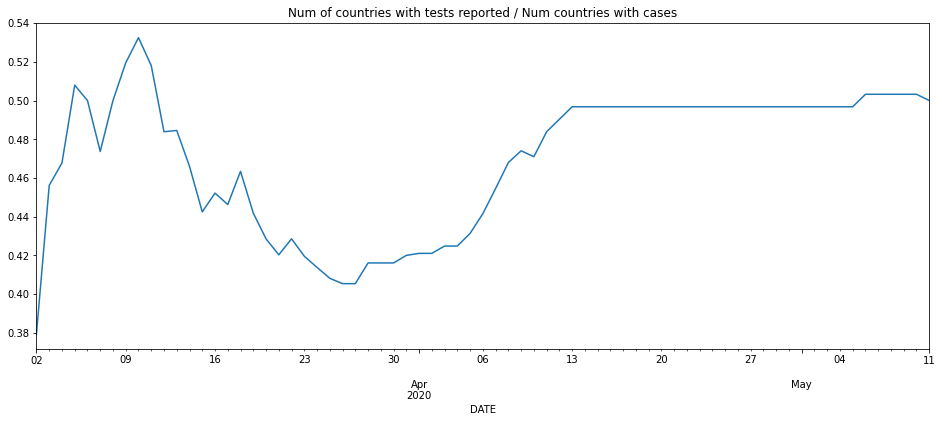

In [49]:
#@title Countries with number of tests data as a proportion of those that have confirmed cases
#@markdown Note that this plot dips as more countries start reporting cases for the first time with the number of cases for those countries being reported later.
fig, ax = plt.subplots(figsize=(16, 6))
countries = df.query(f'DATE > "{start_date}" and total_cases > 0').groupby('DATE')['CountryName'].count()
tests = df.query(f'DATE > "{start_date}" and total_tests > 0').groupby('DATE')['CountryName'].count()
(tests / countries).plot()
plt.title('Num of countries with tests reported / Num countries with cases')
plt.show()

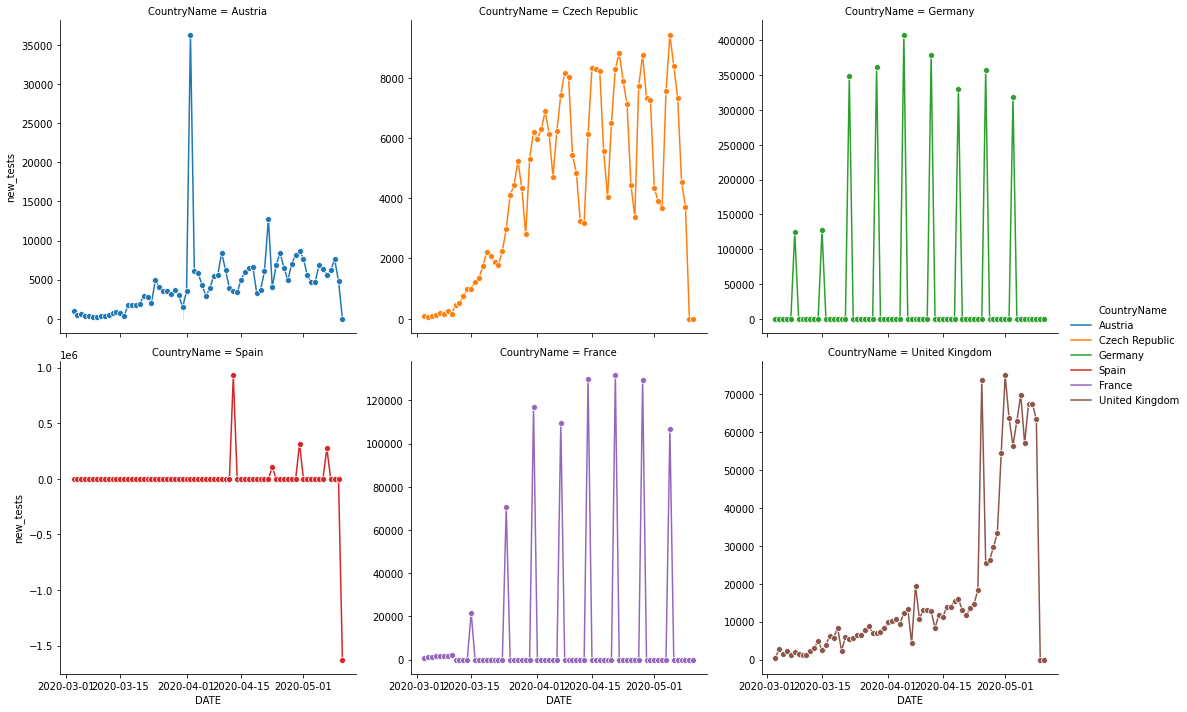

In [77]:
#@title Testing Artifacts
#@markdown We see the periodic nature of reporting of the number of tests conducted in countries like Germany and France and other unusual artifacts in countries like Spain and Austria
plot_df = df[(df.ISO.isin(isos)) & (df.DATE > start_date)].set_index(['ISO', 'DATE'])
plot_df['new_tests'] = plot_df.groupby(level=0).apply(lambda rows: rows.droplevel(level=0).total_tests.diff())

sns.relplot(data=plot_df.reset_index(), x='DATE', y='new_tests', kind='line', col='CountryName', col_wrap=3, marker='o', facet_kws=dict(sharey=False), hue='CountryName')
plt.show()

